Number of members [16, 32, 64, 128, 256]
FZ13 - Average sign time (s):  [0.6468999999999994, 1.082899999999999, 2.012400000000001, 3.951499999999997, 7.820500000000001]
FZ13 - Average key generationy time (s):  [0.1671000000000001, 0.26850000000000057, 0.48589999999999944, 0.9843000000000017, 1.922]
FZ13 - Average verify time (s):  [0.6563000000000004, 1.0033000000000005, 1.970499999999999, 3.8298, 7.687200000000002]
URS - Average key generation time (s):  [0.12959999999999922, 0.24989999999999668, 0.49839999999999235, 0.9981999999999914, 1.9202999999999748]
URS - Average sign time (s):  [0.3157000000000039, 0.40790000000000076, 0.5453999999999951, 0.6438000000000159, 0.775]
URS - Average verify time (s):  [1.3437999999999988, 3.0484000000000036, 7.329700000000014, 16.232899999999994, 36.97660000000002]


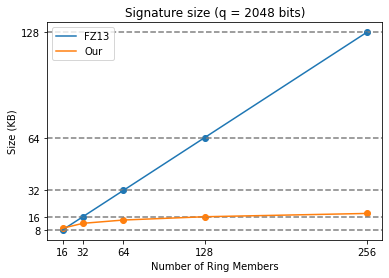

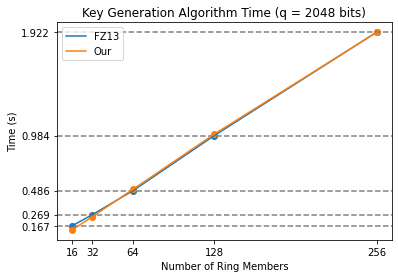

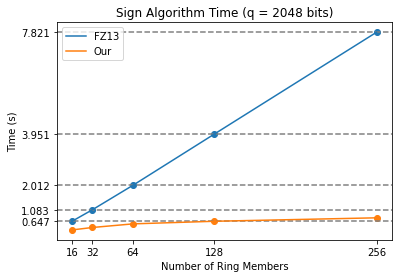

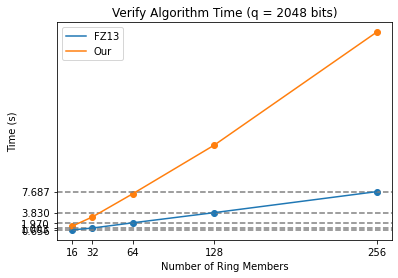

In [4]:
import hashlib
import statistics
import os
import matplotlib.pyplot as plt 

# FZ13
def FZ13_Setup(q):
    pp =[]
    g = randint (1, q-1)
    pp.append(q)
    pp.append(g)
    return pp

# Keygen
def FZ13_RG(pp, N):
    q = pp[0]
    g = pp[1]
    tmp = N-1
    
    x = [randint (1,q-1) for i in range (0,N)]
    y = [power_mod(g,x[i],q) for i in range (0,N)]
    R = y
    
    return R, x, y 

#sign
def FZ13_RS(pp, N, y, x, i, R, m):
    # # Step 1 (Simulation)
    q = pp[0]
    g = pp[1]
    sigma = []
    
    c = [0]*N
    t = [0]*N
    a = [0]*N
    b = [0]*N
    
    rtg = hashlib.sha256()
    rtg.update(m)
    rtg.update(str(R).encode())
    
    hash_val = Integer('0x' + rtg.hexdigest()) # r  = H(M||R)
    
    r = [0] * N
    ab = ""
    sum_c = 0
    
    for j in range (0, N):
        if j != i :
            c[j] = randint (1,q-1)
            t[j] = randint (1,q-1)
            a[j] = (power_mod(g,t[j],q) * power_mod(y[j],c[j],q)) %q
#             b[j] = ((power_mod(hash_val, t[j], q) * power_mod(power_mod(hash_val, x[i], q), c[j], q)) % q)
            b[j] = (power_mod(hash_val, t[j] + x[i]* c[j], q))
            sum_c += c[j]

    #Step 2
        if j == i:
            r[i] = randint (1,q-1)
            a[j] = power_mod(g, r[i], q)
            b[j] = power_mod(hash_val, r[i], q) 

        ab += str(a[j])
        ab += str(b[j])

    #Step 3
    rtg.update(ab.encode())          
    c[i] = (Integer('0x' + rtg.hexdigest()) - sum_c) %q
    t[i] = (r[i] - c[i] * x[i]) % q

    #Step 4
    tau = power_mod(hash_val, x[i], q)
    sigma.append(tau)

    for j in range (0, N):
        sigma.append(c[j])
        sigma.append(t[j])
    return sigma

#Verify
def FZ13_RV(pp, N, y, x, R, m, sigma, i):
    q = pp[0]
    g = pp[1]

    #extract sigma
    ver_tau = sigma[0]
    ver_c = []
    ver_t = []
    for j in range(1, 2*N, 2):
        ver_c.append(sigma[j])
        ver_t.append(sigma[j+1]) 

    rtg = hashlib.sha256()
    rtg.update(m)
    rtg.update(str(R).encode())
    ver_hash_val = Integer('0x' + rtg.hexdigest()) # r  = H(M||R)
    tmp_str = ""
    ver_sum_c = 0
    satisfied = true
    
    for j in range (0, N):
        if i != j:
            tmp =  (power_mod(g, ver_t[j], q) * power_mod(y[j], ver_c[j], q))%q
            hash_val_1 = (power_mod(ver_hash_val, ver_t[j], q) * power_mod(ver_tau, ver_c[j],q)) %q
        else:
            tmp =  power_mod(g, (ver_t[j] + x[j]* ver_c[j]) % q, q)
            hash_val_1 = power_mod(ver_hash_val, (ver_t[j] + x[i]*ver_c[j]) % q,q)
            
        tmp_str += str(tmp)
        tmp_str += str(hash_val_1)
        ver_sum_c += ver_c[j]
    rtg.update(tmp_str.encode())
    vp = Integer('0x' + rtg.hexdigest()) # r  = H(M||R)

    if (ver_sum_c % q != vp % q):
        satisfied = false
    if (satisfied == false):
        print("Satisfied", satisfied)
        
def FZ13_GetSignatureSize(sigma, N):
    bit_size = 0
    ver_tau = sigma[0]
    ver_c = []
    ver_t = []
    for j in range (1, 2*N, 2):
        ver_c.append(sigma[j])
        ver_t.append(sigma[j+1]) 
        
    bit_size += int(ver_tau).bit_length()
    for i in range (0, N):
        bit_size += int(ver_c[i]).bit_length()
        bit_size += int(ver_t[i]).bit_length()
    return int(int(bit_size)/(8*1024))
    
def FZ13(list_n, q, file):
    #read file
    m = b''
    # file need to sign
  
    # file size
    file_size = os.stat(file)
    print(f'File size (MB): {file_size.st_size / (1024 * 1024)}')
    rtg = hashlib.sha256()
    BLOCK_SIZE = 65536

    with open(file, 'rb') as f: 
        fb = f.read(BLOCK_SIZE)
        m += fb
        while len(fb) > 0:
             fb = f.read(BLOCK_SIZE)
    
    avg_keygen_time_list = []
    avg_sign_time_list = []
    avg_verify_time_list = []
    avg_size_sig_list = []
    
    #remove file before update new result
    try:
        os.remove("fz13.txt")
    except:
        print('No such file')
    
    for n in list_n:
        N = power(2,n)
        gen_time_list = []
        sign_time_list = []
        verify_time_list = []
        size_sig_list = []
        
        for j in range (0, 10): # run 10 times
            print("N =", N, "- Interval: ", j)
            # Set up ring
            ring_Z = IntegerRing()
            i = ring_Z(randint (0, N-1)) #signer
            
            # Start algo
            # FZ13_Setup
            pp = FZ13_Setup(q)
            
            # Key Gen
            t1 = cputime()
            R, x, y = FZ13_RG(pp, N)
            gen_time_list.append(cputime(t1))

            # Sign
            t2 = cputime()
            sigma = FZ13_RS(pp, N, y, x, i, R, m)
            sign_time_list.append(cputime(t2))
            
            size = FZ13_GetSignatureSize(sigma, N)
            size_sig_list.append(size)
            # Verify
            t3 = cputime()
            FZ13_RV(pp, N, y, x, R, m, sigma, i)
            verify_time_list.append(cputime(t3))

        avg_gen_time = statistics.mean(gen_time_list)
        avg_sign_time = statistics.mean(sign_time_list)
        avg_verify_time = statistics.mean(verify_time_list)
        avg_size_sig = statistics.mean(size_sig_list)
       
        f = open("fz13.txt", "a")
        s = str(avg_size_sig) + ',' +  str(avg_gen_time) + ',' + str(avg_sign_time) + ','+ str(avg_verify_time) + '\n'
        f.write(s)
        f.close()

        print("Avg gen time:", avg_gen_time)
        print("Avg sign time:", avg_sign_time)
        print("Avg verify time:", avg_verify_time)
        print("")

        avg_keygen_time_list.append(avg_gen_time)
        avg_sign_time_list.append(avg_sign_time)
        avg_verify_time_list.append(avg_verify_time)
        avg_size_sig_list.append(avg_size_sig)
      
    return avg_size_sig_list, avg_keygen_time_list, avg_sign_time_list, avg_verify_time_list
# end of FZ13


# URS
def delta(i,j):
     if i == j:
        return 1
     return 0

def URS_Setup(q):
    # Mức an toàn DLP
    qbit = 2048
    g = randint (1,q-1)
    h = randint (1,q-1)
    
    pp = []
    pp.append(q)
    pp.append(g)
    pp.append(h)
    return pp

def URS_KeyGen(pp, N):
    q = pp[0]
    g = pp[1]
    h = pp[2]
    
    sk = [randint (1,q-1) for i in range (0, N)]
    pk = [power_mod(h,sk[i],q) for i in range (0, N)]
    R = pk
    return R, sk, pk

#sign
def URS_Sign(pp, n, N, M, R , sk, pk, lk):
    q = pp[0]
    g = pp[1]
    h = pp[2]
    
    # Step 1
    ring_Z = IntegerRing()
    l = lk.digits(2)
    
    for count in range (0,n):
        if (len(l) < n):
             l.append(0)

    # Step 2
    rk = []
    s = []
    tk = []
    a = []
    b = []
    rho = []
    cl = []
    ca = []
    cb = []
    
    # Khoảng chạy từ 0 đến n-1
    for j in range (0, n):
        rk.append(randint(1,q-1)) # Sinh r_j
        s.append(randint(1,q-1)) # Sinh s_j
        tk.append(randint(1,q-1)) # Sinh t_j
        a.append(randint(1,q-1)) # Sinh a_j
        b.append(randint(1,q-1)) # Sinh r_j
        if j == 0:
            k = n-1
        else:
            k = j-1
        rho.append(randint(1,q-1)) # Sinh r_j

    # Step 3
    for j in range (0, n):
        cl.append((power_mod(g,l[j],q)*power_mod(h,rk[j],q)) %q) # Tính cl_i 
        ca.append((power_mod(g,a[j],q)*power_mod(h,s[j],q)) %q) # Tính ca_i 
        cb.append((power_mod(g,l[j]*a[j],q)*power_mod(h,tk[j],q)) %q) # Tính cb_i 

    # Step 4
    fz = []
    fz0 = []
    fz1 = []
    ZR.<z> = PolynomialRing(ZZ)
#     ZR = PolynomialRing(ZZ, 'z')
#     z = ZR.gen()
    
    for j in range (0, n):
        fz.append(l[j]*z+a[j]) # Tính fz_i
        fz0.append(delta(0,l[j])*z-a[j]) # Tính f_j,0
        fz1.append(delta(1,l[j])*z+a[j]) # Tính f_j,1
    
    #Step 5
    pzi = []
    pik = []
    z_ring = IntegerRing()
    for i in range (0, N):
        tmp = z_ring(i).digits(2) #2=10b => [0,1]

        #append for tmp has length n
        for count in range (0,n):
            if (len(tmp) < n):
                tmp.append(0)
        tmp1 = 1
        for t in range (n-1,-1,-1):  #n-1,n-2,...,0
            if tmp[t] == 1:
                tmp1 = tmp1*fz1[t]
            else:
                tmp1 = tmp1*fz0[t]
        pzi.append(tmp1)
        co = tmp1.coefficients() # co reversed order

        #append for co has length n
        for count in range (0, n):
            if (len(co) < n):
                co.append(0)
        pik.append(co) 

    #Step 6
    cd = [0]*n
    for k in range (0, n):
        sum = rho[k]

        #calculate power value
        for i in range (0, N):
            sum += pik[i][k] * sk[i]

        cd[k] = power_mod(h,sum,q)

    #  Tính tau
    rtg = hashlib.sha256()
    rtg.update(M)
    rtg.update(str(R).encode())
    r = Integer('0x' + rtg.hexdigest()) % q # r  = H(M||R)

    tau = power_mod(r,sk[lk],q)

    # Calculate ce
    ce = [0]*n
    for k in range (0, n):
        sum = rho[k]

        #calculate power value
        for i in range (0, N):
            sum += pik[i][k] * sk[lk]

        ce[k] = power_mod(r,sum,q)


    #Step 8
    A = []
    for j in range (0, n):
       A.append(cl[j])

    for j in range (0, n):
       A.append(ca[j])

    for j in range (0, n):
       A.append(cb[j])

    for j in range (0, n):
       if (j==0): k = n-1
       else:
            k = j -1
       A.append(cd[k])

    for j in range (0, n):
       if (j==0): k = n-1
       else:
            k = j -1
       A.append(ce[k])

    rtg.update(str(tau).encode())
    rtg.update(str(A).encode())

    X = Integer('0x' + rtg.hexdigest()) % q # X  = HFS(M||R||tau||A)

    #Step 9
    f = []
    za = []
    zb = []
    for j in range (0, n):
        f.append(l[j]*X + a[j])
        za.append(rk[j]*X + s[j])
        zb.append(rk[j]*(X-(l[j]*X + a[j])) + tk[j])

    #Step 10
    zd = sk[lk] * X^n
    for k in range (0, n):
        zd -= rho[k]*X^k

    #Step 11
    sigma = []
    Z = []

    for j in range (0, n):
       Z.append(f[j])

    for j in range (0, n):
       Z.append(za[j])

    for j in range (0, n):
       Z.append(zb[j])

    Z.append(zd)

    sigma.append(tau)
    sigma.append(A)
    sigma.append(Z)
    #print(sigma)
    return sigma

##URS_Verify
def URS_Verify(pp, n, N, M, R, sigma, pk):
    q = pp[0]
    g = pp[1]
    h = pp[2]
    
    #Step 1
    ver_tau = sigma[0]
    ver_A = sigma[1]
    ver_Z = sigma[2]
    
    
    # de A
    ver_cl = ver_A[0:n]
    ver_ca = ver_A[n:2*n]
    ver_cb = ver_A[2*n:3*n]
    ver_cd_tmp = ver_A[3*n:4*n]
    ver_ce_tmp = ver_A[4*n:5*n]

    # re-order cd to equal first cd
    ver_cd = [0]*n
    for j in range (0, n):
       if (j == n-1): k = 0
       else:
            k = j + 1
       ver_cd[j] = ver_cd_tmp[k]

    # re-order ce to equal first ce
    ver_ce = [0]*n
    for j in range (0, n):
       if (j == n-1): k = 0
       else:
            k = j + 1
       ver_ce[j] = ver_ce_tmp[k]

    # Z
    ver_f = ver_Z[0:n]
    ver_za = ver_Z[n:2*n]
    ver_zb = ver_Z[2*n:3*n]
    ver_zd = ver_Z[-1]
    
    #Step 2
    ver_htg = hashlib.sha256()
      
    ver_htg.update(M)
    ver_htg.update(str(R).encode())
    
    ver_r = Integer('0x' + ver_htg.hexdigest()) % q
    
    ver_htg.update(str(ver_tau).encode())
    ver_htg.update(str(ver_A).encode())

    ver_X = Integer('0x' + ver_htg.hexdigest()) % q # X  = HFS(M||R||tau||A)
    #Step 3
    satisfied = true

    for j in range (0, n):
        tmp1 = (power_mod(ver_cl[j],ver_X,q) * ver_ca[j]) %q
        tmp2 = (power_mod(g,ver_f[j],q) * power_mod(h,ver_za[j],q)) % q
        if (tmp1 != tmp2):
            satisfied = false
            break

        tmp3 = (power_mod(ver_cl[j],ver_X - ver_f[j],q) * ver_cb[j]) %q
        tmp4 = power_mod(h,ver_zb[j],q)
        if (tmp3 != tmp4):
            satisfied = false
            break
    
    #Step 4
    ver_fj0 = []
    ver_fj1 = []
    for j in range (0, n):
        ver_fj0.append(ver_X - ver_f[j]) #=> f00, f01, f02
        ver_fj1.append(ver_f[j]) #=> f10, f11, f12

    #Step 5
    ver_pik=[]
    z_ring = IntegerRing()

    for i in range (0, N):
        i_bi = z_ring(i).digits(2)

        #append for tmp has length n
        for count in range (0,n):
            if (len(i_bi) < n):
                i_bi.append(0)

        tmp = 1
        for j in range (n-1,-1,-1):
            if i_bi[j] == 1:
                tmp = (tmp*ver_fj1[j])
            else:
                tmp = (tmp*ver_fj0[j])
        ver_pik.append(tmp)

    #Step 6 and 7
    mul1 = 1
    mul2 = 1
    mul3 = 1
    mul4 = 1
  
    for j in range (0, N):
        mul1 *= power_mod(pk[j], ver_pik[j], q)
        mul3 *= power_mod(ver_tau, ver_pik[j], q)
        mul3 = mul3 % q
        mul1 = mul1 % q
   
    X_tmp = 1    
    for k in range (0, n):
        if (k > 0): 
            X_tmp *= ver_X
            X_tmp = X_tmp % q
        mul2 *= power_mod(ver_cd[k], -X_tmp, q)
        mul4 *= power_mod(ver_ce[k], -X_tmp, q)
        
    if (mul1 * mul2) % q != power_mod(h, ver_zd, q):
        satisfied = false

    if (mul3 * mul4) % q != power_mod(ver_r, ver_zd, q):
            satisfied = false
    if (satisfied == false):
        print("Satisfied", satisfied)

def URS_GetSignatureSize(sigma, n):
    bit_size= 0
    #extract sigma
    ver_tau = sigma[0]
    ver_A = sigma[1]
    ver_Z = sigma[2]
    
    # de A
    ver_cl = ver_A[0:n]
    ver_ca = ver_A[n:2*n]
    ver_cb = ver_A[2*n:3*n]
    ver_cd = ver_A[3*n:4*n]
    ver_ce = ver_A[4*n:5*n]

    # Z
    ver_f = ver_Z[0:n]
    ver_za = ver_Z[n:2*n]
    ver_zb = ver_Z[2*n:3*n]
    ver_zd = ver_Z[-1]
    
    bit_size += int(ver_tau).bit_length()
    bit_size += int(ver_zd).bit_length()
    
    for i in range (0, n):
        bit_size += int(ver_cl[i]).bit_length()
        bit_size += int(ver_ca[i]).bit_length()
        bit_size += int(ver_cb[i]).bit_length()
        bit_size += int(ver_cd[i]).bit_length()
        bit_size += int(ver_ce[i]).bit_length()
        bit_size += int(ver_f[i]).bit_length()
        bit_size += int(ver_za[i]).bit_length()
        bit_size += int(ver_zb[i]).bit_length()
    
    return int(int(bit_size)/(8*1024))
        
def URS(list_n, q, file):    
    # file need to sign
    # file size
    file_size = os.stat(file)
    print(f'File size (MB): {file_size.st_size / (1024 * 1024)}')
    M = b'';

    # read file
    rtg = hashlib.sha256()
    BLOCK_SIZE = 65536
    with open(file, 'rb') as f: 
        fb = f.read(BLOCK_SIZE) 
        M += fb
        while len(fb) > 0:
             fb = f.read(BLOCK_SIZE)
    
    avg_keygen_time_list = []
    avg_sign_time_list = []
    avg_verify_time_list = []
    avg_size_sig_list = []
    
    
    #remove file before update new result
    try:
        os.remove("urs.txt")
    except:
        print('No such file')
    
    for n in list_n:
        gen_time_list = []
        sign_time_list = []
        verify_time_list = []
        size_sig_list = []
        
        N = power(2, n)
        
        for j in range (0, 10): #run 10 times
            print("N =", N, "- Interval: ", j)
            # Setup ring
            ring_Z = IntegerRing()
            lk = ring_Z(randint (0, N-1)) #signer

            # Start
            pp = URS_Setup(q)

            t1 = cputime()
            R, sk, pk = URS_KeyGen(pp, N)
            gen_time_list.append(cputime(t1))

            t2 = cputime()
            sigma = URS_Sign(pp, n, N, M, R, sk, pk, lk)
            sign_time_list.append(cputime(t2))
            
            t3 = cputime()
            URS_Verify(pp, n, N, M, R, sigma, pk)
            verify_time_list.append(cputime(t3))
            
            #Signature size
            size  = URS_GetSignatureSize(sigma, n)
            
            size_sig_list.append(size)
        
        avg_gen_time = statistics.mean(gen_time_list)
        avg_sign_time = statistics.mean(sign_time_list)
        avg_verify_time = statistics.mean(verify_time_list)
        avg_size_sig = statistics.mean(size_sig_list)
        
        f = open("urs.txt", "a")
        s = str(avg_size_sig) + ',' +  str(avg_gen_time) + ',' + str(avg_sign_time) + ','+ str(avg_verify_time) + '\n'
        f.write(s)
        f.close()
        
        print("Avg gen time:", avg_gen_time)
        print("Avg sign time:", avg_sign_time)
        print("Avg verify time:", avg_verify_time)
        
        avg_keygen_time_list.append(avg_gen_time)
        avg_sign_time_list.append(avg_sign_time)
        avg_verify_time_list.append(avg_verify_time)
        avg_size_sig_list.append(avg_size_sig)
        
    return avg_size_sig_list, avg_keygen_time_list, avg_sign_time_list, avg_verify_time_list
#end of URS

def draw_graph(graph_title, x_label, y_label, x_list, y1_list, y1_label, y2_list, y2_label):
    for i in range(0, len(y2_list)):
        plt.axhline(y=y1_list[i], color='gray', linestyle='--') 
    
    # plotting the points
    plt.scatter(x_list, y1_list) 
    plt.scatter(x_list, y2_list) 
    
    plt.plot(x_list, y1_list, label = y1_label) 
    plt.plot(x_list, y2_list, label = y2_label) 
    
    # naming the x axis 
    plt.xlabel(x_label) 
    # naming the y axis 
    plt.ylabel(y_label) 

    
    # giving a title to the graph 
    plt.title(graph_title) 
    plt.legend() 
    plt.xticks(x_list)
    plt.yticks(y1_list)
    
    # function to show the plot 
    plt.show() 

#main
if __name__ == "__main__":
    #trick to run only 1 time and save result to a file (because running takes time)
    f =  open("mark.txt", "a")
    f.write("1"+'\n')
    f.close()
    
    f =  open("mark.txt", "r")
    lines = f.readlines()
    f.close()
    file = "Slide.pdf"
    #end trick
    
    list_n = [4,5,6,7,8] # define n
    
    list_N = [2^i for i in list_n] # number of users in  ring
    qbit = 2048
    # q = random_prime ( 2^qbit , proof=True , lbound=2^(qbit-1) )
    q = 18516841683705576033541506244961206372808908044728439148208084124588361694223183249161587724647339133105075172750090401807781853987333090090564993823128273010593412498417032471119163940790016542900079598607961354667866676794226616388833239394362712140545067902485910306147489783662158342876208146120082300127075170667961343577030443405632161539732221032885322740243318170630987306215049583017095450592742209855302160618381938569194167603386470238917480591863321400427403175826424061933700157932617337395943215436895818408754625760595454438150590028015876809562909908864971775303496181769148652769313496091827545452009
    
    fz13_list_avg_keygen_time = []
    fz13_list_avg_sign_time = []
    fz13_list_avg_verify_time = []
    fz13_list_avg_size_sig = []
    
    urs_list_avg_keygen_time = []
    urs_list_avg_sign_time = []
    urs_list_avg_verify_time = []
    urs_list_avg_size_sig = []
    
    
    if (len(lines) == 1): #trick
        print("START FZ13 !!!")
        #fz13 result
        fz13_list_avg_size_sig, fz13_list_avg_keygen_time, fz13_list_avg_sign_time, fz13_list_avg_verify_time = FZ13(list_n, q, file)
    
        print("START URS !!!")
        #urs result
        urs_list_avg_size_sig, urs_list_avg_keygen_time, urs_list_avg_sign_time, urs_list_avg_verify_time = URS(list_n, q, file)

    else: #if run 2nd time then read last result from file
        # read result from fz13
        try:
            f =  open("fz13.txt", "r")
            lines = f.readlines()
        
            for line in lines:
                data = line.split(',')
                fz13_list_avg_size_sig.append(float(data[0]))
                fz13_list_avg_keygen_time.append(float(data[1]))
                fz13_list_avg_sign_time.append(float(data[2]))
                fz13_list_avg_verify_time.append(float(data[3]))
            f.close()
        except:
            print('No such file')
        
        # result from urs
        try:
            f =  open("urs.txt", "r")
            lines = f.readlines()
            
            for line in lines:
                data = line.split(',')
                urs_list_avg_size_sig.append(float(data[0]))
                urs_list_avg_keygen_time.append(float(data[1]))
                urs_list_avg_sign_time.append(float(data[2]))
                urs_list_avg_verify_time.append(float(data[3]))
            f.close()
        except:
            print('No such file')
       
    print("Number of members", list_N)
    
    print("FZ13 - Average sign time (s): ",fz13_list_avg_sign_time)
    print("FZ13 - Average key generationy time (s): ",fz13_list_avg_keygen_time)
    print("FZ13 - Average verify time (s): ", fz13_list_avg_verify_time)
    
    print("URS - Average key generation time (s): ",urs_list_avg_keygen_time)
    print("URS - Average sign time (s): ",urs_list_avg_sign_time)
    print("URS - Average verify time (s): ",urs_list_avg_verify_time)
    
    
    # Plotting
    #    Signature sign
    draw_graph(graph_title = "Signature size (q = 2048 bits)",
               x_label = "Number of Ring Members", 
               y_label = "Size (KB)", 
               x_list  = list_N,
               y1_list = fz13_list_avg_size_sig, 
               y1_label = "FZ13", 
               y2_list = urs_list_avg_size_sig, 
               y2_label = "Our" )
    
#     Keygen algorithm
    draw_graph(graph_title = "Key Generation Algorithm Time (q = 2048 bits)",
               x_label = "Number of Ring Members", 
               y_label = "Time (s)", 
               x_list  = list_N,
               y1_list = fz13_list_avg_keygen_time, 
               y1_label = "FZ13", 
               y2_list = urs_list_avg_keygen_time, 
               y2_label = "Our" )
    
    # Sign algorithm
    draw_graph(graph_title = "Sign Algorithm Time (q = 2048 bits)",
               x_label = "Number of Ring Members", 
               y_label = "Time (s)", 
               x_list  = list_N,
               y1_list = fz13_list_avg_sign_time, 
               y1_label = "FZ13", 
               y2_list = urs_list_avg_sign_time, 
               y2_label = "Our" )
    
    
#     Verify algorithm
    draw_graph(graph_title = "Verify Algorithm Time (q = 2048 bits)",
               x_label = "Number of Ring Members", 
               y_label = "Time (s)", 
               x_list  = list_N,
               y1_list = fz13_list_avg_verify_time, 
               y1_label = "FZ13", 
               y2_list = urs_list_avg_verify_time, 
               y2_label = "Our" )